In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns


itemCategories= pd.read_csv("../data/item_categories.csv")

itemCategories

items=pd.read_csv("../data/items.csv")

items


sales_train=pd.read_csv("../data/sales_train.csv")

sales_train

sample_submission=pd.read_csv("../data/sample_submission.csv") 
sample_submission

shops= pd.read_csv("../data/shops.csv")
shops

test=pd.read_csv("../data/test.csv")
test



,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


In [3]:
#Changing from object to date format
sales_train['date_string']=sales_train['date'].astype('str')

sales_train.date=sales_train.date_string.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))


In [4]:
print(sales_train.info())
sales_train


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
date_string       object
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 156.8+ MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_string
0,2013-01-02,0,59,22154,999.00,1.0,02.01.2013
1,2013-01-03,0,25,2552,899.00,1.0,03.01.2013
2,2013-01-05,0,25,2552,899.00,-1.0,05.01.2013
3,2013-01-06,0,25,2554,1709.05,1.0,06.01.2013
4,2013-01-15,0,25,2555,1099.00,1.0,15.01.2013
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,10.10.2015
2935845,2015-10-09,33,25,7460,299.00,1.0,09.10.2015
2935846,2015-10-14,33,25,7459,349.00,1.0,14.10.2015
2935847,2015-10-22,33,25,7440,299.00,1.0,22.10.2015


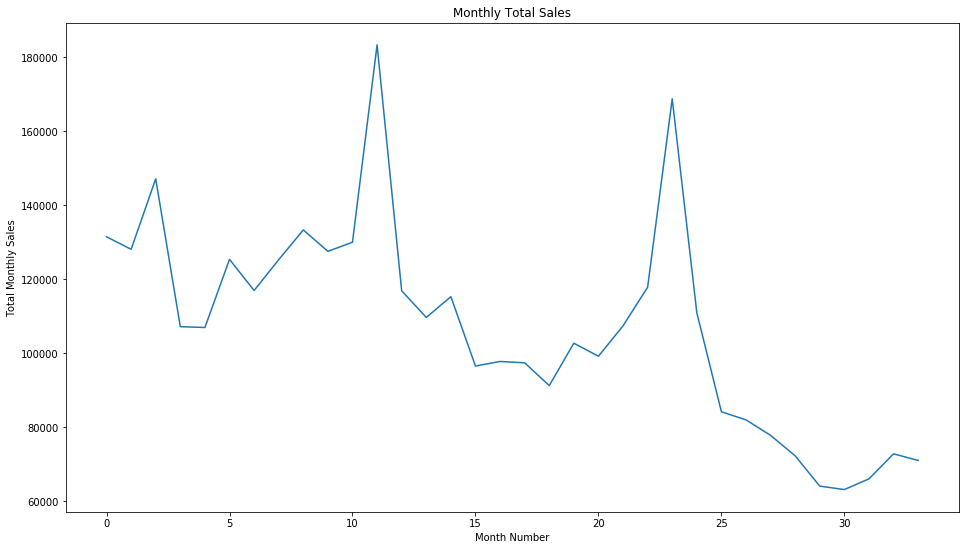

In [5]:
#date_block_num is consecutive month number
#time series for monthly sales

totalSales_ts= sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
plt.figure(figsize=(16,9))
plt.title('Monthly Total Sales')
plt.xlabel("Month Number")
plt.ylabel("Total Monthly Sales")
plt.plot(totalSales_ts)



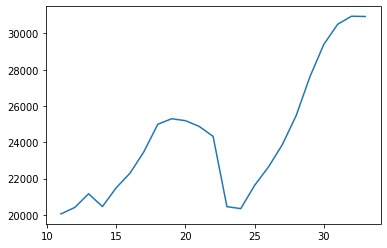

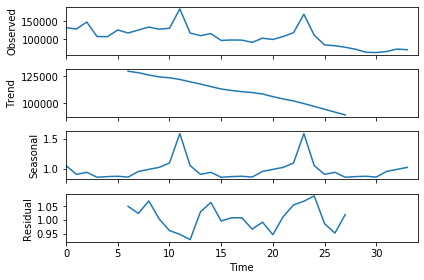

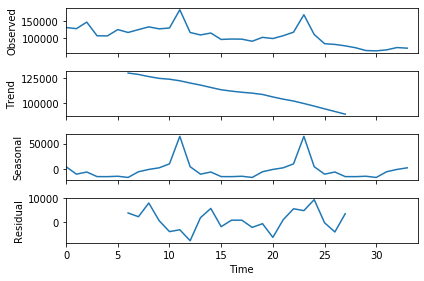

In [6]:
import statsmodels.api as sm
#Assuming our ts model to be multiplicatice 
plt.plot(totalSales_ts.rolling(window=12).std())
#Check whether multiplicative or additive by checking if acf is smaller for additive model or multiplicative
res=sm.tsa.seasonal_decompose(totalSales_ts.values,freq=12, model="multiplicative")
fig= res.plot()


#Additive model
res=sm.tsa.seasonal_decompose(totalSales_ts.values,freq=12, model="additive")
fig= res.plot()


#cant reallt tell which one is better should we use acf values



In [7]:
from statsmodels.tsa.stattools import adfuller
#dickey Fuller test
#creating a function for checking whether Time series is stationary
#yUSHENG THIS FUNCTION IS AVAILABLE ON INTERNET EVERYWHERE SO YOU CAN ALWAYS COPY PASTE THIS 
def adfz_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    


adfz_test(totalSales_ts)

# P value 

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [8]:
# From ADF Test satistics> ADF hence we reject null hypotheisis hence series not satitionary:
#Detrending it by log to make time series well behaved or stationary by taking log. (assuming no negative sales)
 
totalSales_df=sales_train.groupby(["date_block_num"]).sum()['item_cnt_day']
#pd.DataFrame({"Block_num"})
totalSales_df=totalSales_df.reset_index()

totalSales_df['log_cnt_day']= np.log(totalSales_df['item_cnt_day'])

totalSales_df

totalSales_df.rename(columns={'log_cnt_day':'log_cnt'})


,date_block_num,item_cnt_day,log_cnt
0,0,131479.0,11.786602
1,1,128090.0,11.760488
2,2,147142.0,11.899153
3,3,107190.0,11.582358
4,4,106970.0,11.580304
5,5,125381.0,11.739112
6,6,116966.0,11.669639
7,7,125291.0,11.738394
8,8,133332.0,11.800598
9,9,127541.0,11.756193


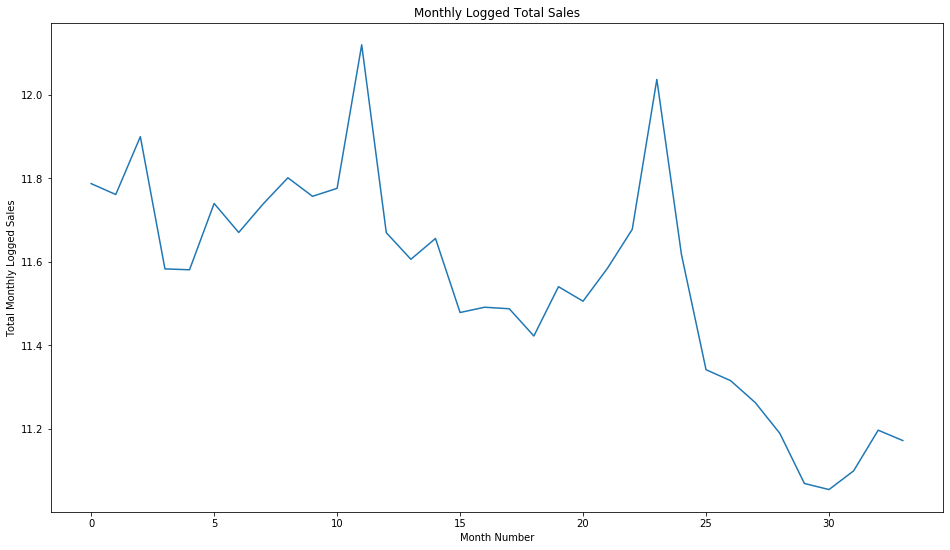

In [9]:
log_ts= totalSales_df[['date_block_num','log_cnt_day']]
log_ts = log_ts.set_index('date_block_num')

plt.figure(figsize=(16,9))
plt.title('Monthly Logged Total Sales')
plt.xlabel("Month Number")
plt.ylabel("Total Monthly Logged Sales")
plt.plot(log_ts)



In [10]:
log_ts
log_ts_test = log_ts.iloc[:,0].values

adfz_test(log_ts_test)


#still not detrended



Results of Dickey-Fuller Test:
Test Statistic                 -1.738099
p-value                         0.411597
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [11]:
#differenced to remove anymore trend
diff_ts=log_ts.diff()
diff_ts=diff_ts.dropna()
diff_ts_test=diff_ts.iloc[:,0].values

adfz_test(diff_ts_test)
#trend removed 

Results of Dickey-Fuller Test:
Test Statistic                -6.974163e+00
p-value                        8.513200e-10
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [12]:
#groupby shop and item, and then transform to time series data 
train = sales_train.groupby(['shop_id','item_id','date']).sum().reset_index()
train = train[['shop_id','item_id','date','item_cnt_day']]
train = train[train['item_cnt_day']>0]
train = pd.pivot_table(train,index=['shop_id','item_id'],columns='date',values='item_cnt_day',fill_value=0).reset_index()
train.head()

date,shop_id,item_id,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-07 00:00:00,2013-01-08 00:00:00,...,2015-10-22 00:00:00,2015-10-23 00:00:00,2015-10-24 00:00:00,2015-10-25 00:00:00,2015-10-26 00:00:00,2015-10-27 00:00:00,2015-10-28 00:00:00,2015-10-29 00:00:00,2015-10-30 00:00:00,2015-10-31 00:00:00
0,0,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#merge with test data
data = pd.merge(test,train,on=['shop_id','item_id'],how='left')
#fill NaN with 0
data.fillna(0,inplace=True)
#set ID as index, date time as cols
Data = data.drop(columns=['shop_id','item_id'])
Data.set_index('ID',inplace=True)
Data.head()

,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2015-06-30    0.672703
2015-07-31    0.672703
2015-08-31    0.672703
2015-09-30    1.646468
2015-10-31    0.672703
2015-11-30    0.185820
2015-12-31    0.276293
2016-01-31    0.320342
2016-02-29    0.341789
2016-03-31    0.352231
2016-04-30    0.357316
2016-05-31    0.359791
Freq: M, dtype: float64


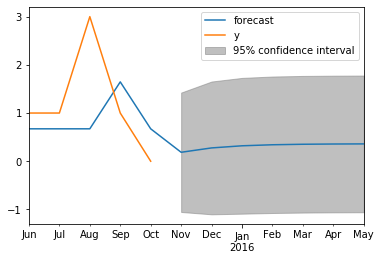

Forecasting 1 obs. took  0.4838216304779053  s
Forecasting 214200 obs. will take  28.787387013435364  h


In [16]:
#use simple AR model to predict one shop-item sales 
#time the process of predicting one obs.

import time
start_time=time.time()

from statsmodels.tsa.arima_model import ARMA

mod = ARMA(Data.T[0].resample('M').sum(),order=(1,0))
res = mod.fit()
res.summary()
print(res.predict(start='2015-06-30',end=40))
res.plot_predict(start='2015-06-30',end=40)
plt.show()

end_time=time.time()
print("Forecasting 1 obs. took ",end_time-start_time," s")
print("Forecasting 214200 obs. will take ", (214200*(end_time-start_time))/3600, ' h')

In [14]:
adfuller(Data.T[0].resample('M').sum()) #it's a nonstationary random walk

(1.3383754017704799,
 0.9968153920884422,
 10,
 23,
 {'1%': -3.7529275211638033,
  '5%': -2.998499866852963,
  '10%': -2.6389669754253307},
 54.08361384683882)

In [60]:
from numpy import sqrt

sample_1 = Data.T[0].resample('M').sum()
sample_1= sqrt(sample_1)
sample_1= sample_1.diff()

#sample_1 = sample_1.replace([np.inf, -np.inf], np.nan)
#print(sample_1.isna().sum())
sample_1.dropna(inplace=True)


 
adfuller(sample_1) 
# Test value smaller than critical value.


(-4.082084925824894,
 0.0010367123492856908,
 6,
 26,
 {'1%': -3.7112123008648155,
  '5%': -2.981246804733728,
  '10%': -2.6300945562130176},
 42.84542906318014)

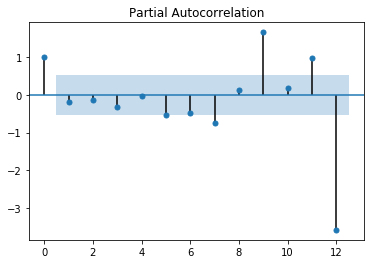

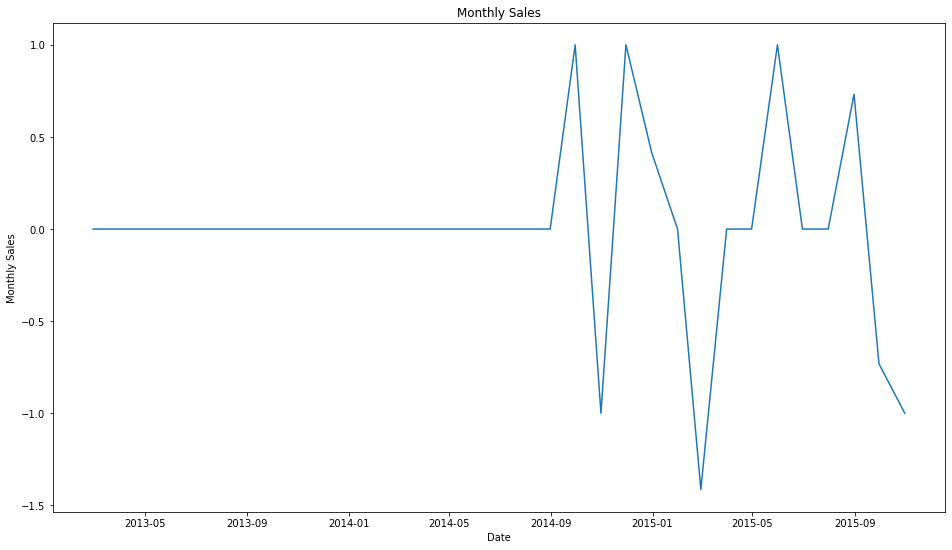

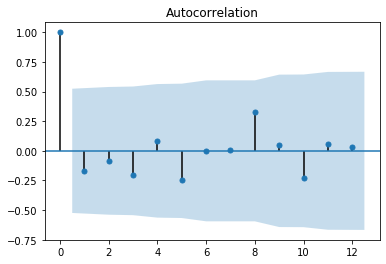

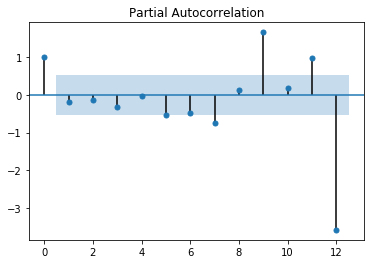

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16,9))
plt.title('Monthly Sales')
plt.xlabel("Date")
plt.ylabel("Monthly Sales")
plt.plot(sample_1)

plot_acf(sample_1.loc["2014-09":])
plot_pacf(sample_1.loc["2014-09":])

#DO you see the problem. We cant use ARMA because of weird PACF and ACF function ROFL. WE need to change model.


In [71]:
#use simpe arma model to predict one shop-item sales
#the sample contains too many zeros hence after detrending, cannot perform arma model, any idea?

import time
start_time=time.time()

from statsmodels.tsa.arima_model import ARMA

mod = ARMA(sample_1,order=(1,1)) 
res = mod.fit()
res.summary()
print(res.predict(start='2015-06-30',end=40))
res.plot_predict(start='2015-06-30',end=40)
plt.show()

end_time=time.time()
print("Forecasting 1 obs. took ",end_time-start_time," s")
print("Forecasting 214200 obs. will take ", (214200*(end_time-start_time))/3600, ' h')

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [21]:
#preprocess data again to include item_category as a feature;
#should we include item_price as well? how to pivot the table that case?
#resample date to month
train = pd.read_csv('../data/sales_train.csv',parse_dates = ['date'], infer_datetime_format = True, dayfirst = True)
items = pd.read_csv('../data/items.csv')
train = train[train['item_cnt_day']>0]
data = train.groupby(['shop_id','item_id','date']).sum().reset_index()
data = data[['shop_id','item_id','date','item_cnt_day']]
data = pd.pivot_table(data,index=['shop_id','item_id'],columns='date',values='item_cnt_day',fill_value=0).reset_index()
data.head()

date,shop_id,item_id,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-07 00:00:00,2013-01-08 00:00:00,...,2015-10-22 00:00:00,2015-10-23 00:00:00,2015-10-24 00:00:00,2015-10-25 00:00:00,2015-10-26 00:00:00,2015-10-27 00:00:00,2015-10-28 00:00:00,2015-10-29 00:00:00,2015-10-30 00:00:00,2015-10-31 00:00:00
0,0,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
data = pd.merge(test,data,on=['shop_id','item_id'],how='left')
data = pd.merge(data,items,on='item_id',how='left')
data.fillna(0,inplace=True)
data.set_index('ID',inplace=True)
data.head()

,shop_id,item_id,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-07 00:00:00,2013-01-08 00:00:00,...,2015-10-24 00:00:00,2015-10-25 00:00:00,2015-10-26 00:00:00,2015-10-27 00:00:00,2015-10-28 00:00:00,2015-10-29 00:00:00,2015-10-30 00:00:00,2015-10-31 00:00:00,item_name,item_category_id
ID,,,,,,,,,,,,,,,,,,,,,
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ONE DIRECTION Made In The A.M.,55
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Need for Speed [PS4, русская версия]",20


In [23]:
cols = data.columns.to_list()
cols = cols[:2] + [cols[-1]] + cols[2:-2]
data = data[cols]

In [25]:
features = data.iloc[:,0:3]
timesteps = data.iloc[:,3:]
timesteps = timesteps.T
timesteps.index = pd.to_datetime(timesteps.index)
timesteps = timesteps.resample('M').sum()
timesteps.index = timesteps.index.strftime('%Y-%m')
timesteps = timesteps.T
data = pd.concat([features,timesteps],axis=1)
data.head()

,shop_id,item_id,item_category_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
ID,,,,,,,,,,,,,,,,,,,,,
0,5,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#not sure how cross_validation and/or train_test_split work with ts data, since the order of time matters
#also why are cross_val scores negative? what scoring metrics should we choose?
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
scores_lr = cross_val_score(lr, X, y, cv=3)
print(scores_lr)

rg = Ridge()
scores_rg = cross_val_score(rg, X, y, cv=3)
print(scores_rg)

ls = Lasso()
scores_ls = cross_val_score(ls, X, y, cv=3)
print(scores_ls)

[ 0.20376258 -0.51096373 -1.63187975]
[ 0.20376275 -0.51095481 -1.63186434]
[0.16815116 0.24209283 0.04353334]
